In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, Model, utils, optimizers, models
from tensorflow.keras.layers import Conv2D,concatenate, Activation, BatchNormalization, MaxPooling2D, Dropout,Conv2DTranspose, UpSampling2D
import json
from tqdm import tqdm

#STD and time analysis
import sys
import time

## Function Definitions

Here we define the loss function, which is dice loss. We use dice loss address the problem of class imbalance.


We also define a convolutional block to add two conv layers.


Finally, we define the model in the get_unet function

In [2]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

    return 1 - (numerator + 1) / (denominator + 1)

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = UpSampling2D((2,2), interpolation='bilinear')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = UpSampling2D((2,2), interpolation='bilinear')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = UpSampling2D((2,2), interpolation='bilinear')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = UpSampling2D((2,2), interpolation='bilinear')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

## Read in the data and define our datasets

In [3]:
def post_proc(mask, std):
    ret, thresh = cv2.threshold(mask, std, 255, cv2.THRESH_BINARY)
    
    #Close gaps in mask and dilate
    kernel_c = np.ones((2,2),np.uint8)
    kernel_d = np.ones((5,5),np.uint8)

    mask_proc = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_c)
    mask_proc = cv2.dilate(mask_proc,kernel_d,iterations = 1)
    return mask_proc

#Read configuration file
with open('config.json') as f:
    config = json.load(f)

IMG_W = config['image_width']
IMG_H = config['image_height']

win_w = config['window_width']
win_h = config['window_height']

scaled_win_w = config['model_input_width']
scaled_win_h = config['model_input_height']

num_win_x = IMG_W/win_w
num_win_y = IMG_H/win_h

image_dir = './Images/'
mask_dir = './Masks/'

img_names = os.listdir(image_dir)
mask_names = os.listdir(mask_dir)

#Due to labelling software, might need to rename the image names
RENAME_IMAGES = False

X = []
y = []

#Because of annotation software, there may be a mismatch in naming
if RENAME_IMAGES:
    for img_name in img_names:
        img_path_curr = os.path.join(image_dir, img_name)
        img_path_lower = os.path.join(image_dir, img_name.lower())
        os.rename(img_path_curr, img_path_lower)
    #After renaming, get img_names again
    img_names = os.listdir(image_dir)

#Data Collection
for i in tqdm(range(len(img_names)), desc='Collecting Data'):

    #Obtain mask and image paths
    mask_path = os.path.join(mask_dir, mask_names[i])
    img_name = mask_names[i].split('_mask')[0]+'.jpg'
    assert img_name in img_names, 'Expected {} in {}, if image filename is uppercase, use --ri = True'.format(img_name, args['images'])
    img_path = os.path.join(image_dir, img_name)

    #Read mask and img in
    mask = cv2.imread(mask_path, 0)
    ret, thresh = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
    img = cv2.imread(img_path)
    scaled_img = cv2.resize(img, (128, 128))/255.0
    scaled_mask = cv2.resize(thresh, (128, 128))/255.0

    X.append(scaled_img)
    y.append(scaled_mask)

X = np.asarray(X)
y = np.asarray(y)

NameError: name 'model' is not defined

## Training the Model

In [ ]:
#If a model already exists we can pass its path in to further train
MODEL_PATH = False

#Hyperparameters
EPOCHS = 50
BATCH_SIZE = 16
VAL_SPLIT = 0.15

if not MODEL_PATH:
    print('No model path given, creating new model')

    #Model Definition
    num_channels = 3 #bgr

    inputs = layers.Input((128, 128, num_channels))

    model = get_unet(inputs)

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=dice_loss, metrics=[dice_loss,'accuracy'])

else:
    print('Model path specified, loading model')

    try:
        model = models.load_model(MODEL_PATH, compile=False) 
        model.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss=dice_loss, metrics=[dice_loss,'accuracy'])

    except Exception as e:
        print(e)

#reshape y
if len(y.shape) < 4:
    y = np.expand_dims(y, axis=3)

#Shuffle
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

history = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)

model.save('unet_model')

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.plot(history.history['acc'], label='accuracy')
ax.plot(history.history['val_acc'], label='validation_accuracy')
ax.plot(history.history['dice_loss'], label='dice_loss')
ax.plot(history.history['val_dice_loss'], label='validation_dice_loss')
ax.set_xlabel('Epoch')
plt.legend()
plt.savefig('history.png')

print('Model saved')

## Run the Model

In [ ]:
def post_proc(mask, std):
    ret, thresh = cv2.threshold(mask, std, 255, cv2.THRESH_BINARY)
    
    #Close gaps in mask and dilate
    kernel_c = np.ones((2,2),np.uint8)
    kernel_d = np.ones((5,5),np.uint8)

    mask_proc = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_c)
    mask_proc = cv2.dilate(mask_proc,kernel_d,iterations = 1)
    return mask_proc

#Read configuration file
with open('config.json') as f:
    config = json.load(f)

IMG_W = config['image_width']
IMG_H = config['image_height']

win_w = config['window_width']
win_h = config['window_height']

num_win_x = int(IMG_W/win_w)
num_win_y = int(IMG_H/win_h)

#Ensure Image size divides evenly by win_w and win_h
scaled_img_w = win_w*num_win_x
scaled_img_h = win_h*num_win_y

#Path to artifactless dataset
image_dir = '../artifact_segmentation/artifactless/'
model_path = './unet_model'
#Folder to save segmented images
output_folder = './markers'
#Color of segmentation
color = [0,0,255]
#Whether to also output the mask
OUTPUT_MASKS = True

#Load model in with custom loss function
try:
    model = models.load_model(model_path, compile=False) 
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=dice_loss, metrics=[dice_loss,'accuracy'])

except Exception as e:
    print(e)

img_names = os.listdir(image_dir)

#Data Collection
for img_name in tqdm(img_names, desc='Segmenting Markers'):
    X = []

    #Obtain image path
    img_path = os.path.join(image_dir, img_name)

    #Read image
    img = cv2.imread(img_path)

    #Resize image to ensure integer number of patches fit within
    img_scaled = cv2.resize(img, (scaled_img_w, scaled_img_h))

    #Create image patches
    cols = np.arange(0, num_win_x*win_w, win_w)
    rows = np.arange(0, num_win_y*win_h, win_h)
    for row in rows:
        for col in cols:
            win_img = img_scaled[col:col+win_w,row:row+win_w,:]/255.0
            X.append(win_img)

    X = np.asarray(X)

    #Get y patches
    y = model.predict(X)

    #Create mask
    mask = np.zeros((num_win_x*win_w, num_win_y*win_h))

    cols = np.arange(0, num_win_x*win_w, win_w)
    rows = np.arange(0, num_win_y*win_h, win_h)

    #Get scaled standard deviation of predictions
    std = np.std(y)*255.0

    for i in range(len(rows)):
        for j in range(len(cols)):
            patch = y[(i*num_win_x)+j]
            patch = np.reshape(patch, patch.shape[:2]) #remove last dimension
            patch = post_proc(patch*255, std)
            mask[cols[j]:cols[j]+win_w,rows[i]:rows[i]+win_h] = patch

    resized_mask = cv2.resize(mask, (IMG_W, IMG_H))

    #Make output image copy
    img_o = img.copy()
    idx = np.where(resized_mask == 255)
    img_o[idx] = color

    if OUTPUT_MASKS:
        output_path = os.path.join(output_folder,img_name.split('.')[0] + '_mask.jpg')
        cv2.imwrite(output_path, resized_mask)

    output_path = os.path.join(output_folder,img_name.split('.')[0] + '_labelled.jpg')
    cv2.imwrite(output_path, img_o)


## Investigating Low STD predictions and Time bottlenecks

In [5]:
def post_proc(mask, std):
    ret, thresh = cv2.threshold(mask, std, 255, cv2.THRESH_BINARY)
    
    #Close gaps in mask and dilate
    kernel_c = np.ones((2,2),np.uint8)
    kernel_d = np.ones((5,5),np.uint8)

    mask_proc = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_c)
    mask_proc = cv2.dilate(mask_proc,kernel_d,iterations = 1)
    return mask_proc

#Read configuration file
with open('config.json') as f:
    config = json.load(f)

IMG_W = config['image_width']
IMG_H = config['image_height']

win_w = config['window_width']
win_h = config['window_height']

padding = config['padding']

padless_win_w = win_w-2*padding
padless_win_h = win_h-2*padding

num_win_x = int(IMG_W/win_w)
num_win_y = int(IMG_H/win_h)

#Ensure Image size divides evenly by win_w and win_h
scaled_img_w = win_w*num_win_x
scaled_img_h = win_h*num_win_y

#Path to artifactless dataset
image_dir = '../artifact_segmentation/artifactless/'
model_path = './unet_model'
#Folder to save segmented images
output_folder = './markers'
#Color of segmentation
color = [0,0,255]
#Whether to also output the mask
OUTPUT_MASKS = True

#Minimum STD - remove artifacting due to low input signals
STD_THRESH = 5

#Time analysis
time_report = []

#Load model in with custom loss function
#tic = time.time()
try:
    model = models.load_model(model_path, compile=False) 
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=dice_loss, metrics=[dice_loss,'accuracy'])

except Exception as e:
    print(e)
#toc = time.time()
#time_report.append("Model Loading:\t\t%f s" % (toc-tic))

img_names = os.listdir(image_dir)

#Collect stds for full dataset
stds = []

#Want to plot min std
min_std = sys.maxint #Overkill for sure, but covers my bases
min_mask = np.zeros((IMG_W, IMG_H))
min_img = np.zeros((IMG_W, IMG_H))
min_img_o = np.zeros((IMG_W, IMG_H))

#Data Collection
for img_name in tqdm(img_names, desc='Segmenting Markers'):
    X = []

    #Obtain image path
    img_path = os.path.join(image_dir, img_name)

    #Read image
    img = cv2.imread(img_path)

    #Resize image to ensure integer number of patches fit within
    img_scaled = cv2.resize(img, (scaled_img_w, scaled_img_h))

    #Create image patches
    #tic = time.time()
    cols = np.arange(0, num_win_x*win_w, win_w)
    rows = np.arange(0, num_win_y*win_h, win_h)
    for row in rows:
        for col in cols:
            win_img = img_scaled[col:col+win_w,row:row+win_w,:]/255.0
            
            padless_win_img = cv2.resize(win_img, (padless_win_w, padless_win_h))
            scaled_win_img = cv2.copyMakeBorder( padless_win_img, padding, padding, padding, padding, cv2.BORDER_REPLICATE)
        
            X.append(scaled_win_img)
    #toc = time.time()
    #time_report.append("Creating Patches:\t\t%f s" % (toc-tic))
    
    X = np.asarray(X)

    #Get y patches
    #tic = time.time()
    y = model.predict(X)
    #toc = time.time()
    #time_report.append("Prediction:\t\t%f s" % (toc-tic))

    #Create mask
    mask = np.zeros((num_win_x*win_w, num_win_y*win_h))

    cols = np.arange(0, num_win_x*padless_win_w, padless_win_w)
    rows = np.arange(0, num_win_y*padless_win_h, padless_win_h)

    #Get scaled standard deviation of predictions
    std = np.std(y)*255.0
    stds.append(std)
    #tic = time.time()
    for i in range(len(rows)):
        for j in range(len(cols)):
            patch = y[(i*num_win_x)+j][padding:-padding,padding:-padding] #remove padding
            patch = np.reshape(patch, patch.shape[:2]) #remove last dimension
            patch = post_proc(patch*255, max(STD_THRESH,std))
            mask[cols[j]:cols[j]+padless_win_w,rows[i]:rows[i]+padless_win_h] = patch
    #toc = time.time()
    #time_report.append("Assembling Mask:\t\t%f s" % (toc-tic))
    
    if std < min_std:
        resized_mask = cv2.resize(mask, (IMG_W, IMG_H))
        #Make output image copy
        img_o = img.copy()
        idx = np.where(resized_mask == 255)
        img_o[idx] = color
        
        min_mask = resized_mask
        min_img = img
        min_img_o = img_o
        min_std = std
    
#     print(10*'#')
#     for elem in time_report:
#         print(elem)
#         print('\n')
#     print(10*'#')
#     if OUTPUT_MASKS:
#         output_path = os.path.join(output_folder,img_name.split('.')[0] + '_mask.jpg')
#         cv2.imwrite(output_path, resized_mask)

#     output_path = os.path.join(output_folder,img_name.split('.')[0] + '_labelled.jpg')
#     cv2.imwrite(output_path, img_o)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Segmenting Markers: 100%|██████████| 135/135 [02:38<00:00,  1.17s/it]


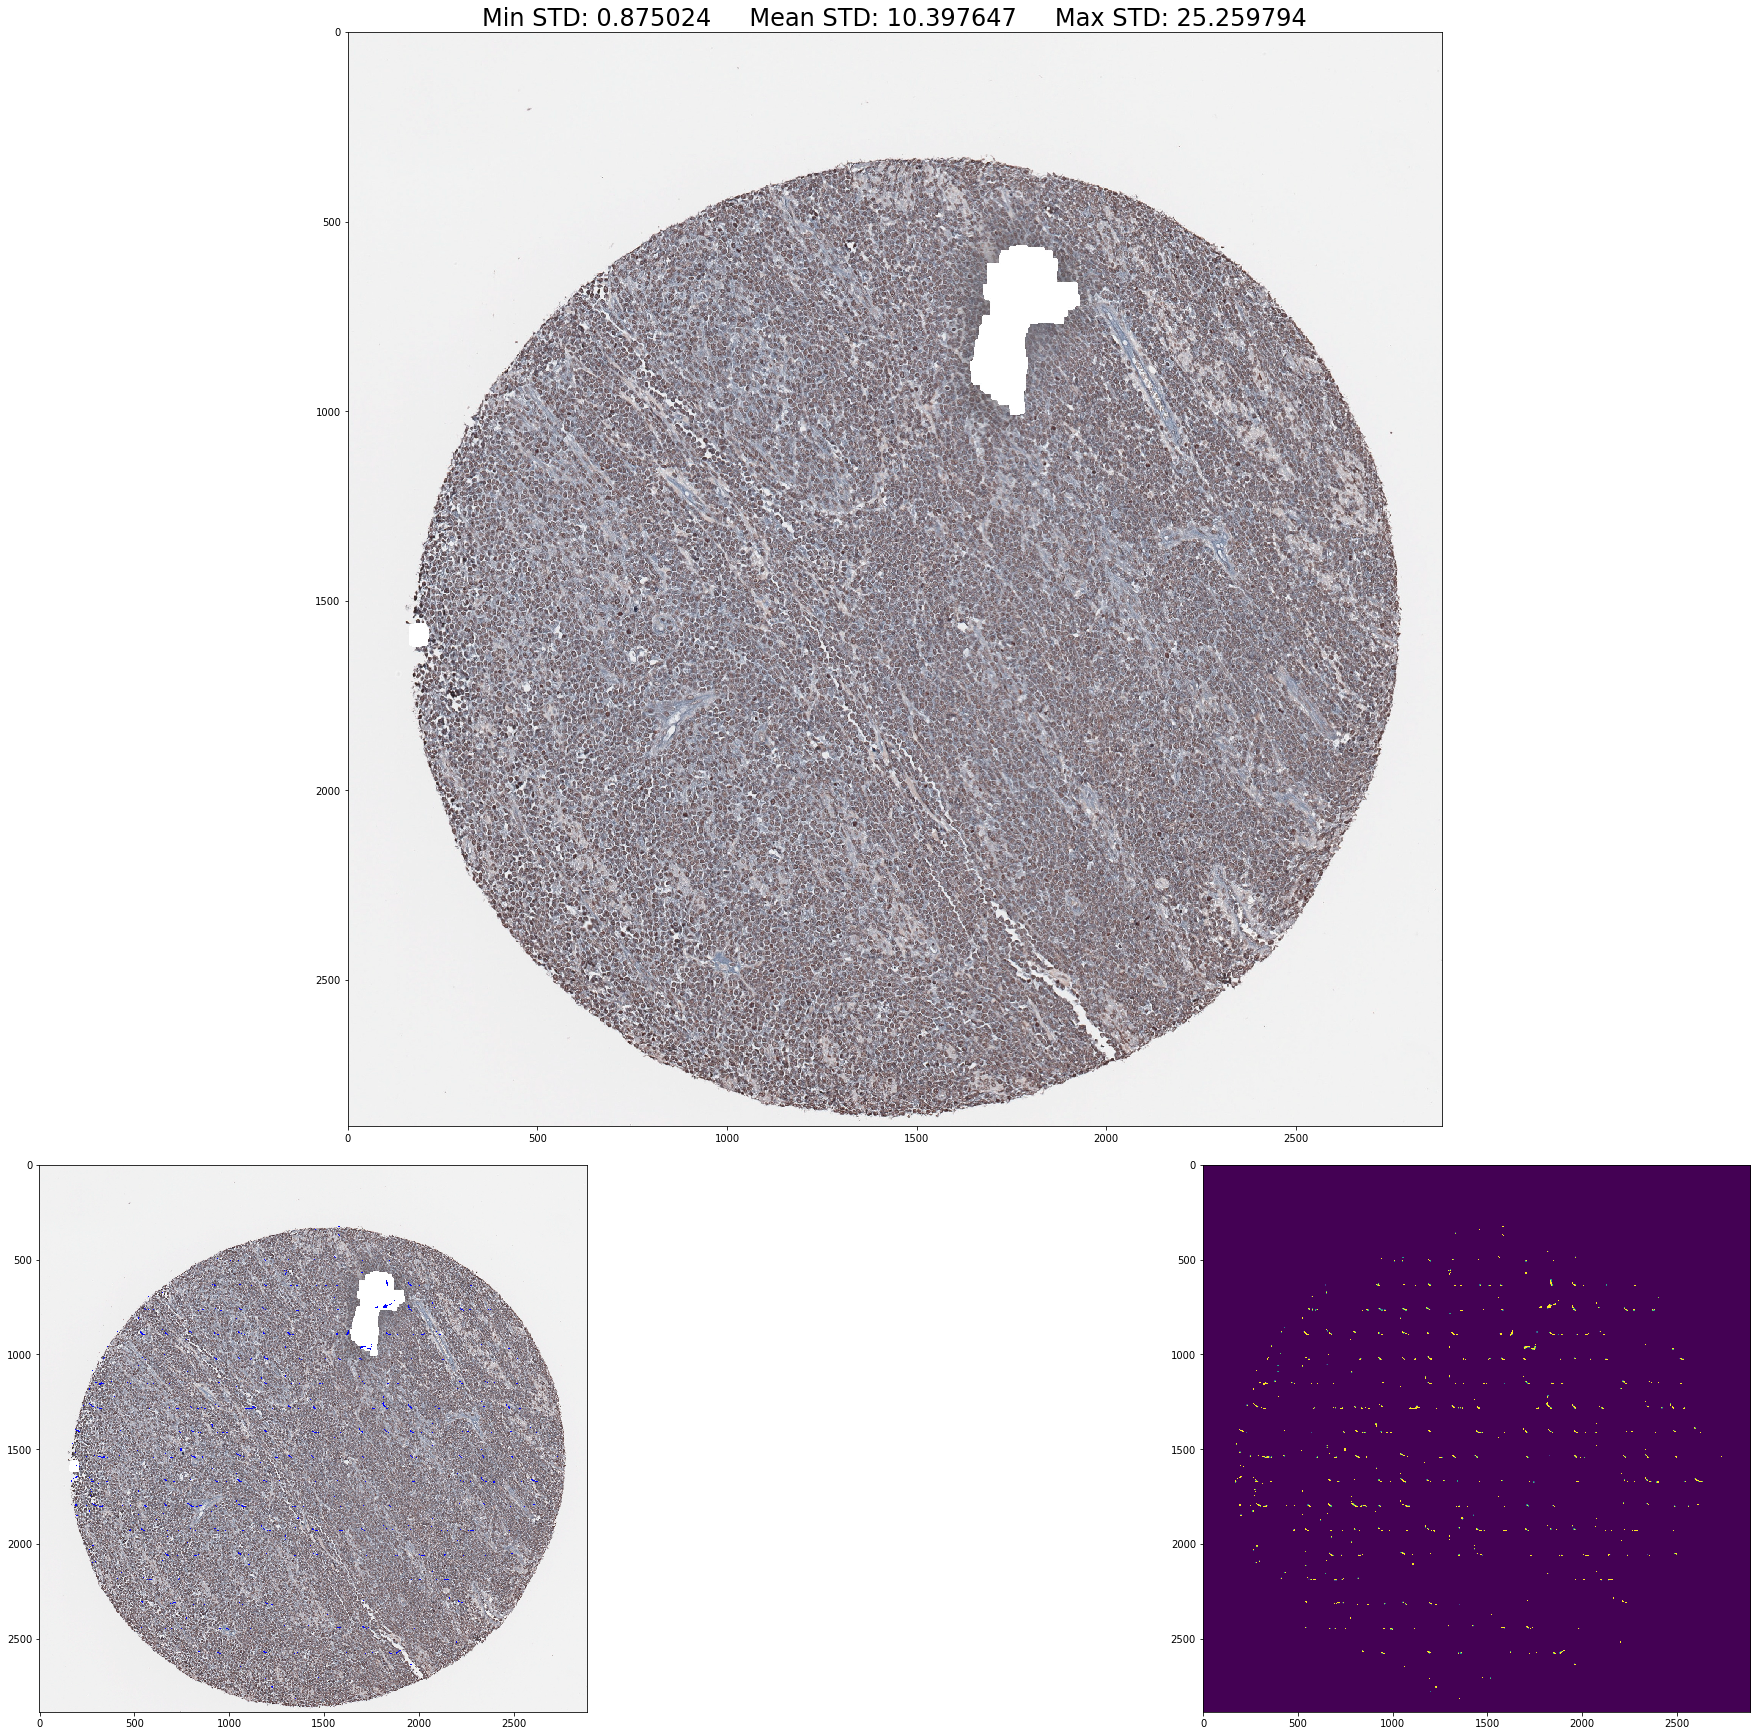

In [6]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(32,24)
fig.set_facecolor('w')

gs = GridSpec(3,2, figure=fig)

ax1 = fig.add_subplot(gs[:2,:]) #Image
ax1.imshow(min_img)
ax1.set_title("Min STD: %f     Mean STD: %f     Max STD: %f" % (min_std, np.mean(stds), np.max(stds)), fontsize=24)
ax2 = fig.add_subplot(gs[2,0]) #Img out
ax2.imshow(min_img_o)
ax3 = fig.add_subplot(gs[2,1]) #Mask out
ax3.imshow(min_mask)
plt.show()



From that rudementary time analysis, we see that the most time-consuming part of the process is the model prediction, which takes around 3.5/4 seconds.

Furthermore, by using max(STD_THRESH, std) we get rid of all the noise in low input signals.

## Removing the Background

In [78]:
test_img = '../artifact_segmentation/artifactless/tFL H_1_1_2_FOXP3_artifactless.jpg'
img = cv2.imread(test_img) 
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.0 #Normalize
img_inv = 1.0 - img_gray
ret, thresh = cv2.threshold(img_inv, np.std(img_inv), 1.0, cv2.THRESH_BINARY)
kernel_c = np.ones((25,25),np.uint8)
mask_proc = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_c)


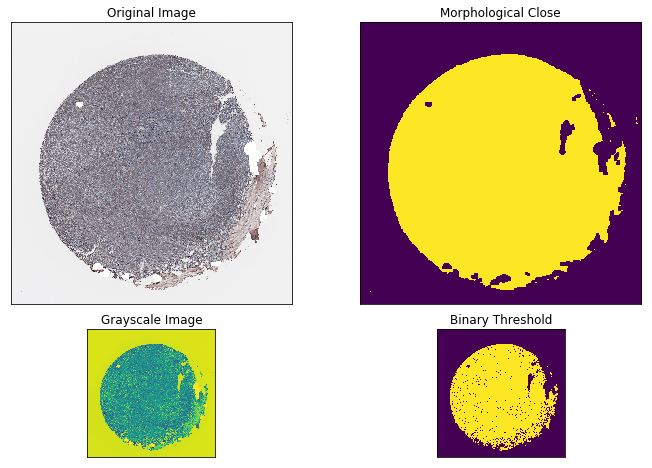

In [79]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=[12,8])
fig.set_facecolor('w')
gs = GridSpec(3,4,figure=fig, hspace=0.2, wspace=0.2)

ax0 = fig.add_subplot(gs[:2,:2])
ax1 = fig.add_subplot(gs[:2,2:])
ax2 = fig.add_subplot(gs[2,:2])
ax3 = fig.add_subplot(gs[2,2:])

for ax in [ax0, ax1, ax2, ax3]:
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

ax0.imshow(img)
ax0.set_title('Original Image')
ax1.imshow(mask_proc)
ax1.set_title('Morphological Close')
ax2.imshow(img_gray)
ax2.set_title('Grayscale Image')
ax3.imshow(thresh)
ax3.set_title('Binary Threshold')
plt.savefig('filter_background.png')
plt.show()


From this test image we see that inverting the image and taking a threshold, followed by a morphological closing operation results in a solid mask of our TMA Core. We can then use this along with the masks from marker segmentation to obtain a percentage of marker.

In [81]:
np.sum(mask_proc)

4272116.0

In [82]:
name = "tFL_C_1_3_11_FOXP3_artifactless"

In [85]:
elems = name.split('_')
grouping = elems[0]
block = elems[1]
sector = elems[2]
row = elems[3]
col = elems[4]

In [86]:
import pandas as pd

In [90]:
columns = ['Index','Grouping','Block','Sector','Row','Col','Positivity']
df = pd.DataFrame( columns=columns)

In [91]:
df = pd.read_pickle('./markers/output.pickle')

In [92]:
df.head() .replace(" ", "_")

Empty DataFrame
Columns: [Grouping, Block, Sector, Row, Col, Positivity]
Index: []

In [93]:
name = 'tFL C_1_3_11_FOXP3_artifactless'

In [94]:
name.replace(' ',"_")

'tFL_C_1_3_11_FOXP3_artifactless'